### PyMC3 -> Tensorflow Probability로 변경

- pymc3가 활용하는 theano가 거의 죽어버려서,tensorflow를 활용하는 tensorflow probability로 급하게 선회하여 진행하였다.

공식 github에도 2.0 이상의 버전을 지원하지 않아 엄청난 삽질의 연속이었다.

In [1]:
import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse

#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import matplotlib
matplotlib.rc('font', family='Malgun Gothic') # 한글표시
plt.rc('axes', unicode_minus=False) # 마이너스 기호 표시

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python38\\site-packages\\tensorflow\\_api\\v2\\config\\__init__.py'>

## 3.1 베이지안 지형

- 미지수가 N개인 베이지안 추론 문제를 설정할 때 암묵적으로 기존에 있는 사전확률분포를 위한 N차원 공간을 만듦
- 공간과 관련된 것이 추가 차원인데, 표면(surface) 또는 곡선(curve)라고 말하는 것으로 이는 특정한 위치의 사전확률을 반영하는 공간의 상단을 말함
- 공간 위 표면은 사전확률분포로 정의됨


- 예를 들어 만일 미지수개 두 개, 즉 p1과 p2가 있고 둘의 사전확률분포가 Uniform(0, 5)라면 만들어진 공간은 한 변의 길이가 5인 정사각형이고 표면은 그 정사각형 위에 있는 평면

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('font', family='Malgun Gothic') # 한글표시
plt.rc('axes', unicode_minus=False) # 마이너스 기호 표시
figsize(12.5, 4)

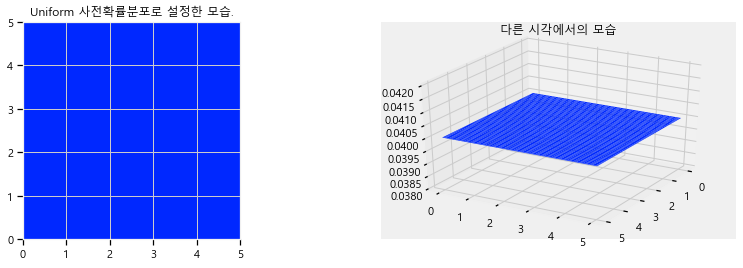

In [3]:
jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Uniform 사전확률분포로 설정한 모습.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("다른 시각에서의 모습");

- 또한, 두 사전확률 분포가 $Exp(3)$과 $Exp(10)$ 이라면 공간은 2차원 평면에서 모두 상수임. 그리고 사전확률분포로 유도한 표면은 좌표 0,0에서 시작하여 흘러가는 폭포로 보임

<Figure size 900x432 with 0 Axes>

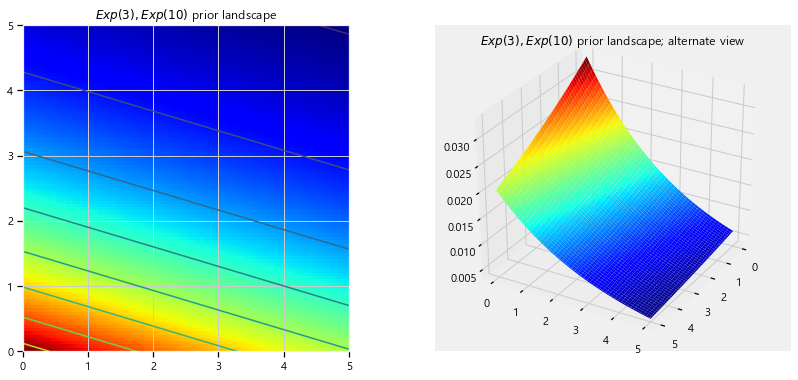

In [4]:
exp_x = tfd.Exponential(rate=(1./3.)).prob(x)
exp_y = tfd.Exponential(rate=(1./10.)).prob(y)

M = tf.matmul(tf.expand_dims(exp_x, 1), tf.expand_dims(exp_y, 0))

plt.figure(figsize(12.5, 6))
jet = plt.cm.jet
fig = plt.figure()
plt.subplot(121)
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title(r"$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=30)
plt.title(r"$Exp(3), Exp(10)$ prior landscape; alternate view");

- 데이터 X는 공간을 변화시키지는 않지만, 사전확률 표면이라는 옷감을 당기고 늘림으로써 공간의 표면을 변화시켜 모수가 존재하는 위치를 반영함
- 새롭게 구성된 표면과 비교하여 원래 표면의 주름이 펴지거나 무의미할 수 있음


- 각각 미지의 모수 $\lambda$를 가진 두 포아송분포를 추론한다고 가정해보자. 균등 사전확률분포와 지수사전확률분포를 사용하여 두 미지수 $\lambda$를 비교.
- 데이터 포인트 한 개를 관찰했다고 가정하고, 전과 후의 베이지안 지형을 시각화 함

In [5]:
# 관측 데이터를 만듬. 우리가 관측한 데이터의 크기(100 이내에서 값을 바꾸어 시도)
N = 1

# 진짜 모수(값이 뭔지 모름)
lambda_1_true = 1.
lambda_2_true = 3.

data = tf.concat([
    tfd.Poisson(rate=lambda_1_true).sample(sample_shape=(N, 1), seed=4),
    tfd.Poisson(rate=lambda_2_true).sample(sample_shape=(N, 1), seed=8)
], axis=1)

data = tf.cast(data, tf.float64)

print("observed (2-dimensional,sample size = %d): \n" % N, data)

# plotting details
x = y = np.linspace(.01, 5, 100)

likelihood_x = tf.math.reduce_prod(tfd.Poisson(rate=x).prob(data[:, 0][:, tf.newaxis]), axis=0)
likelihood_y = tf.math.reduce_prod(tfd.Poisson(rate=y).prob(data[:, 1][:, tf.newaxis]), axis=0)

L = tf.matmul(likelihood_x[:, tf.newaxis], likelihood_y[tf.newaxis, :])
L = tf.cast(L, tf.float64)

observed (2-dimensional,sample size = 1): 
 tf.Tensor([[0. 2.]], shape=(1, 2), dtype=float64)


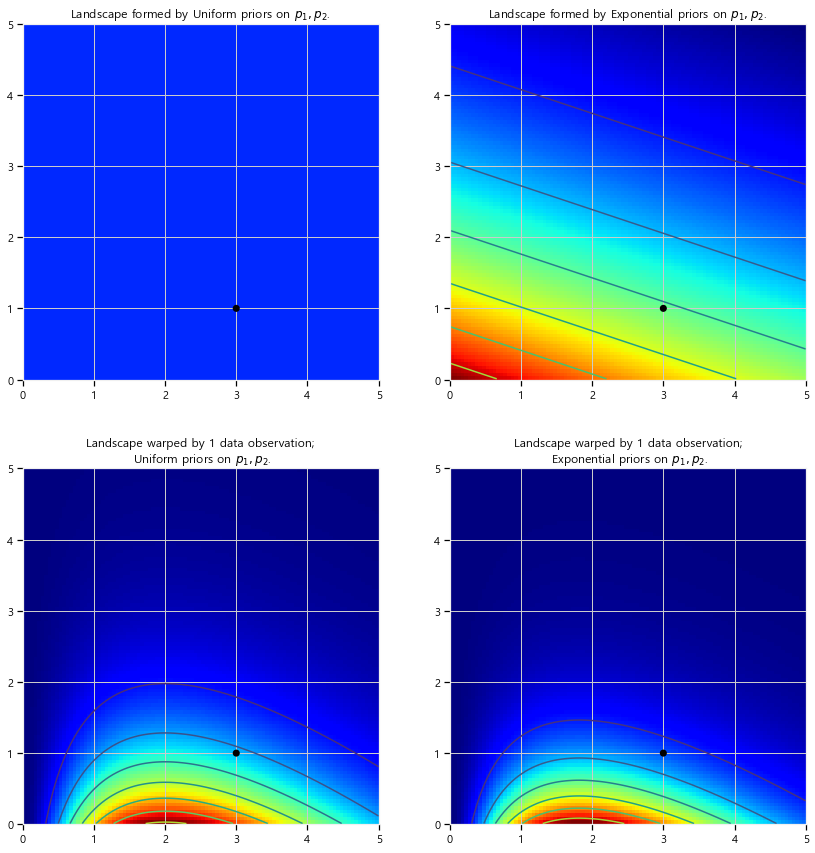

In [6]:
plt.figure(figsize=(12.5, 15))
plt.subplot(221)


# SUBPLOT for regular Uniform
uni_x = tfd.Uniform(low=0., high=5.).prob(tf.cast(x, tf.float32))
m = np.median(uni_x[uni_x >0])
m = uni_x[uni_x == 0]

uni_y = tfd.Uniform(low=0., high=5.).prob(tf.cast(y, tf.float32))
m = np.median(uni_y[uni_y > 0])
m = uni_y[uni_y == 0]

M = tf.cast(tf.matmul(tf.expand_dims(uni_x, 1), tf.expand_dims(uni_y, 0)), tf.float64)

im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title(r"Landscape formed by Uniform priors on $p_1, p_2$.")


# SUBPLOT for Uniform + Data point
plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)


# SUBPLOT for regular Exponential
plt.subplot(222)
exp_x = tfd.Exponential(rate=.3).prob(x)
exp_y = tfd.Exponential(rate=.10).prob(y)
M = tf.cast(tf.matmul(tf.expand_dims(exp_x, 1), tf.expand_dims(exp_y, 0)), tf.float64)
plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

# SUBPLOT for Exponential + Data point
plt.subplot(224)

# 이는 prior likelihood에 따른 사후적인 결과
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on $p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

### 3.1.1. MCMC를 사용하여 지형 탐색하기

- MCMC 이면에 숨겨진 아이디어는 차원의 저주를 벗어나 공간을 지능적으로 검색하는 것.
- 검색이란 우리가 특정한 지점을 찾고있다는 의미로, 정확한 설명은 아니지만 실제 넓은 산을 찾는 것과 비슷함.


- MCMC는 분포 자체가 아닌 사후확률분포의 표본을 돌려줌.
- 원래의 산을 다시 만들 수 있다는 희망을 가지고 가능성 있는 내가 발견한 조약돌이 내가 찾으려는 산에서 나올 가능성이 얼마나 될지 확인하며, 수천 개의 조약돌을 돌려줌으로써 임무를 완수함
- 수렴(converge)은 MCMC의 진행을 표현하기에 정확한 용어는 아님. MCMC는 공간의 넓은 영역을 향해 이동하고, 랜덤하게 그 영역으로 걸어 들어가 영역에서 표본을 채취하는 것.


- 수천 개의 표본이 필요한 이유
    1. 산맥에 대한 수학 공식을 돌려주는 것은 임의의 꼭대기와 계곡을 가진 N차원 표면을 묘사하는 것과 관련있을 것이고, 쉽지 않음
    2. 지형의 정상(산의 가장 높은 지점)을 돌려주는 것은 수학적으로 가능하고 현명한 방법 같지만(가장 높은 지점이 미지수의 가장 가능성 있는 추정값), 지형의 형태를 무시하는 방법. 이는 미지수의 사후적 신뢰도를 알아내려고 할 때 매우 중요함
    
    
- 계산상의 이유 외에도 표본을 돌려주는 가장 큰 이유는 대수의 법칙을 사용하는 것이 쉽기 때문.
- 수천 개의 표본을 히스토그램으로 정리하여 사후확률 분포의 평면을 다시 구축할 수 있음


### 3.1.2. MCMC 수행 알고리즘
- 알고리즘의 대다수는 다음과 같이 고차원수준으로 표현됨
1. 현재 위치에서 시작
2. 새로 이동할 위치를 조사
3. 데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각(조약돌이 그 산에서 나올 가능성을 조사)
4. (a) 수용한다면 새로운 위치로 이동하고 1단계로 이동 </br> (b) 그렇지 않으면 이동하지 말고 1단계로 이동
5. 수많은 반복 후에 모든 가능성 위치를 돌려줌


- 이런 방법으로 사후확률분포가 존재하는 지역ㅇ르 향해 이동하고, 이동 중에 표본을 수집함.
- 일단 사후확률분포에 도달하면 모두 사후확률분포에 속할 가능성이 있으므로 표본을 쉽게 모을 수 있음


- MCMC 알고리즘의 현재 위치가 극도로 낮은 확률 영역이면 사후확률분포에서 나온 것이 아닌 위치로, 근처를 제외한 좀 더 나은 위치로 이동
- 그래서 알고리즘의 첫 이동은 사후확률분포를 반영하지 않음(이 내용은 나중에 다룸)


- 슈도코드에서 중요한 것은 오로지 현재 위치(새로운 위치는 현재 위치 근처에서만 파악됨). 이런 속성을 비기억성(memorylessness)라고 표현함.
- 즉, 알고리즘은 현재 위치에 어떻게 도착했는지에는 관심 없고, 오직 거기에 있다는 점만 중요함


### 3.1.3. 사후확률분포에 대한 다른 접근법
- MCMC 외에도 사후확률분포를 알아내는 다른 방법들이 있음. 라플라스 근사법은 간단한 함수를 사용하여 사후확률분포의 근사치를 구하는 방법이고, 더 고차원적인 방법은 변분 베이즈(variational bayes).
- MCMC, variational bayes, laplace approx 모두 장단점이 있음. 책에서는 MCMC만 다룸


### 3.1.4. 예제: 혼합모델을 사용한 비지도 클러스터링
- 다음과 같은 데이터셋이 주어졌다고 가정

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


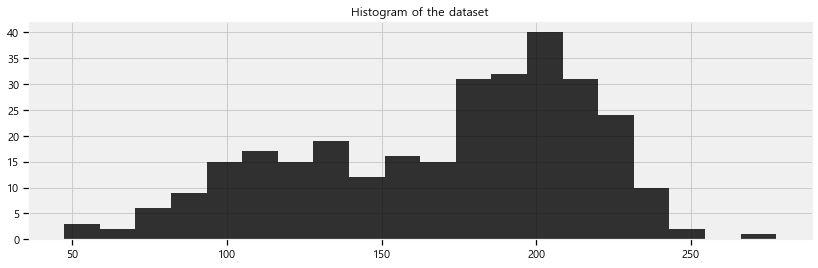

In [7]:
figsize(12.5, 4)
data = np.loadtxt('mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

- 이 데이터 셋에는 클러스터가 두 개 있을 수 있음. 2장의 데이터 생성 모델링 기법의 좋은 예. 우리는 데이터가 어떻게 만들어지는 지 보여줄 수 있음.

1. 각 데이터 포인트에 대해 p의 확률을 가진 클러스터 1을 선택하거나 클러스터 2를 선택함
2. 1단계에서 선택한 클러스터의 모수가 $\mu_i$와 $\sigma_i$인 정규확률분포에서 확률변수를 뽑음
3. 반복

In [8]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1-p1
p = tf.stack([p1, p2])

rv_assignments = tfd.Categorical(name='assignment', probs=p)
assignment = rv_assignments.sample(sample_shape=data.shape[0])

print("prior assignment, with p = %.2f:" % p[0])
print (assignment[:10])

prior assignment, with p = 0.61:
tf.Tensor([1 0 1 1 0 1 0 0 0 0], shape=(10,), dtype=int32)


- 두 정규확률분포의 표준편차가 다르다는 것을 짐작 가능함. 표준편차가 무엇인지 모르는 상태를 유지하기 위해 처음에는 0과 100 사이의 균등 확률분포로서 표준편차를 모델링함.
- TFP 코드 한 줄을 사용하여 모델에 두 표준편차를 모두 포함함.


- 또한, 클러스터의 중심에 대한 사전확률을 구체화함. 중심은 실제 정규확률분포에서 모수 $\mu$임. 
- $\mu_0 = 120, \mu_1=190, \sigma_0 = \sigma_1 = 10$ 로 우선 설정.


- 그리고, MixtureSameFamily 분포를 사용하여 두 정규 분포의 혼합을 구현함. 

In [9]:
rv_sds = tfd.Uniform(name='rv_sds', low=[0., 0.], high=[100., 100.])
rv_centers = tfd.Normal(name='rv_centers', loc=[120., 190.], scale=[10., 10.])

sds = rv_sds.sample()
print ("shape of sds sample:",sds.shape)
centers = rv_centers.sample()

rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = rv_assignments.sample(sample_shape=10)

# observation 과 결합
rv_observations = tfd.MixtureSameFamily(mixture_distribution=rv_assignments,
                                       components_distribution=tfd.Normal(loc=centers,
                                                                         scale=sds))

observations = rv_observations.sample(sample_shape=10)

print("simulated data: ", observations[:4], "...")
print("Random assignments: ", assignments[:4], "...")
print("Assigned center: ", centers[:4], "...")
print("Assigned standard deviation: ", sds[:4],"...")

shape of sds sample: (2,)
simulated data:  tf.Tensor([ 51.844482 141.9107   151.73798  131.75983 ], shape=(4,), dtype=float32) ...
Random assignments:  tf.Tensor([1 0 0 0], shape=(4,), dtype=int32) ...
Assigned center:  tf.Tensor([135.1578  156.36337], shape=(2,), dtype=float32) ...
Assigned standard deviation:  tf.Tensor([50.08224 79.97021], shape=(2,), dtype=float32) ...


- log_prob 함수를 활용하여 평균과 표준편차의 prior를 반영한 클러스터를 생성함
- 그런다음, Categorical Variable에 의해 결정된 가중치에 비례하여 이들을 혼합시켜 혼합 가우시안 분포를 생성함


- 이 모델은 cluster assignment variable을 marginal 시킴.
- 나머지 모든 확률변수가 연속적이므로 HamiltonianMonteCarlo와 같은 간단한 MCMC를 사용할 수 있음.

In [10]:
def joint_log_prob(data, sample_prob_1, sample_centers, sample_sds):
    '''
    args:
        data: tensor array representation of original data
        sample_prob_1: Scalar representing probability (out of 1.0) of assignment being 0
        sample_sds: 2d vector contatining standard deviations for both normal dists in model
        sample_centers: 2d vector containing centers for both normal dists in model
    Return:
        Joint log probability optimization function.
    '''
    
    ### Create a mixture of two scalar Gaussians:
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sds = tfd.Uniform(name='rv_sds', low=[0., 0.], high=[100., 100.])
    rv_centers = tfd.Normal(name='rv_centers', loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(mixture_distribution=rv_assignments,
                                           components_distribution=tfd.Normal(loc=sample_centers,
                                                                             scale=sample_sds))
    
    return (rv_prob.log_prob(sample_prob_1)
           + rv_prob.log_prob(sample_prob_2)
           + tf.reduce_sum(rv_observations.log_prob(data)) # sum samples
           + tf.reduce_sum(rv_centers.log_prob(sample_centers)) # sum components
           + tf.reduce_sum(rv_sds.log_prob(sample_sds))) # sum components

- HMC sampling methods를 이용하여 25000번 샘플링

In [11]:
number_of_steps = 25000
burnin = 1000
num_leapfrog_steps = 3

# Set the chain's start state.
initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([80., 230.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

# we need to transform the samples so they live in real-space
unconstraing_bijectors = [
    tfp.bijectors.Identity(), 
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over out joint_log_prob
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data, *args)

# Defining the HMC
# hmc = tfp.mcmc.TransformedTransitionKernel(inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unnormalized_posterior_log_prob,
#                                                                                       num_leapfrog_steps=num_leapfrog_steps,
#                                                                                       step_size=np.float64(.5),
#                                                                                       step_size_update_fn=tfp.mcmc.SimpleStepSizeAdaptation(num_adaptation_steps=int(burnin * 0.8)),
#                                                                                       ),
#                                           bijector=unconstraing_bijectors)

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob, 
            step_size=np.float64(.5), 
            num_leapfrog_steps=num_leapfrog_steps),
        num_adaptation_steps=int(burnin * 0.8)),
    bijector=unconstraing_bijectors)

In [12]:
# sample from the chain
# [posterior_prob, posterior_centers, posterior_sds], kernel_results = tfp.mcmc.sample_chain(num_results=number_of_steps,
#                                                                                            num_burnin_steps=burnin,
#                                                                                            current_state=initial_chain_state,
#                                                                                            kernel=hmc)


# sample_chain을 tf.function에 래핑하여 재사용 가능한 파일을 미리 컴파일하도록 시킴 - 계산비용 향상
@tf.function
def run_chain(initial_state, num_results, num_burnin_steps):
    return tfp.mcmc.sample_chain(
        num_results=number_of_steps,
        num_burnin_steps=burnin,
        current_state=initial_chain_state,
        kernel=hmc,
        trace_fn=lambda cs, kr: kr)

In [13]:
kernel_result = run_chain(initial_state=initial_chain_state, num_results=number_of_steps, num_burnin_steps=burnin)

In [14]:
posterior_1 = kernel_result.all_states

new_step_size_initializer = kernel_result.trace.inner_results.inner_results.is_accepted.numpy().mean()
print(f'acceptance rate: {new_step_size_initializer}')

acceptance rate: 0.79844


- 매개변수(center, precisions, p) 추적

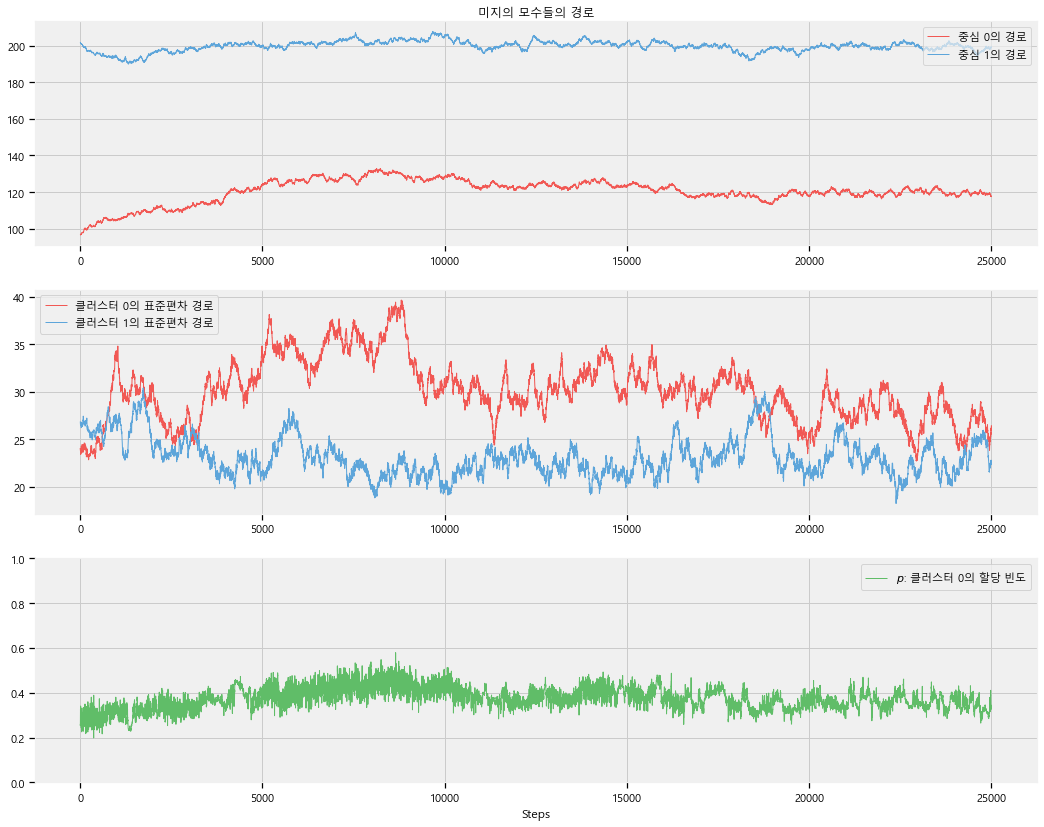

In [15]:
figsize(16, 14)
plt.subplot(311)
lw=1
center_trace = posterior_1[1]

# 색깔 예쁘게하기
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] else [TFColor[0], TFColor[3]]


plt.plot(center_trace[:, 0], label="중심 0의 경로", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="중심 1의 경로", c=colors[1], lw=lw)
plt.title("미지의 모수들의 경로")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = posterior_1[2]
plt.plot(std_trace[:, 0], label="클러스터 0의 표준편차 경로", c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="클러스터 1의 표준편차 경로", c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_1[0]
plt.plot(p_trace, label="$p$: 클러스터 0의 할당 빈도",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

- 위의 그림에서 다음 특징을 확인할 수 있음


1. 경로는 수렴하는데, 하나의 점으로 수렴하는 것이 아니라 가능한 점들의 분포로 수렴한. 이것이 MCMC 알고리즘의 수렴
2. 처음에 수천 개의 점을 사용한 추론은 좋은 아이디어가 아님. 우리가 관심 있는 최종 분포와는 상관없기 때문.
    - 그래서 추론용 표본을 사용하기 전에 그 표본들을 버리는 게 좋음.
    - 수렴 이전의 이런 기간을 번인 기간(burn-in period)라고 함
3. 경로는 공간에서 '랜덤워크'로 나타남. 즉, 경로는 이전 위치와 상관관계를 보임. 현재 위치와 이전 위치 간의 상관성을 가짐.
    - 지나친 상관성은 공간을 잘 탐색한 것이 아님.

In [16]:
number_of_steps=100000
burnin=10000

# Set the chain's start state.
initial_chain_state = [
    tf.constant(posterior_1[0][-1], name='init_probs_2'),
    tf.constant(posterior_1[1][-1], name='init_centers_2'),
    tf.constant(posterior_1[2][-1], name='init_sds_2')
]

In [17]:
kernel_result = run_chain(initial_state=initial_chain_state, num_results=number_of_steps, num_burnin_steps=burnin)

In [18]:
posterior_2 = kernel_result.all_states

new_step_size_initializer = kernel_result.trace.inner_results.inner_results.is_accepted.numpy().mean()
print(f'acceptance rate: {new_step_size_initializer}')

acceptance rate: 0.70911


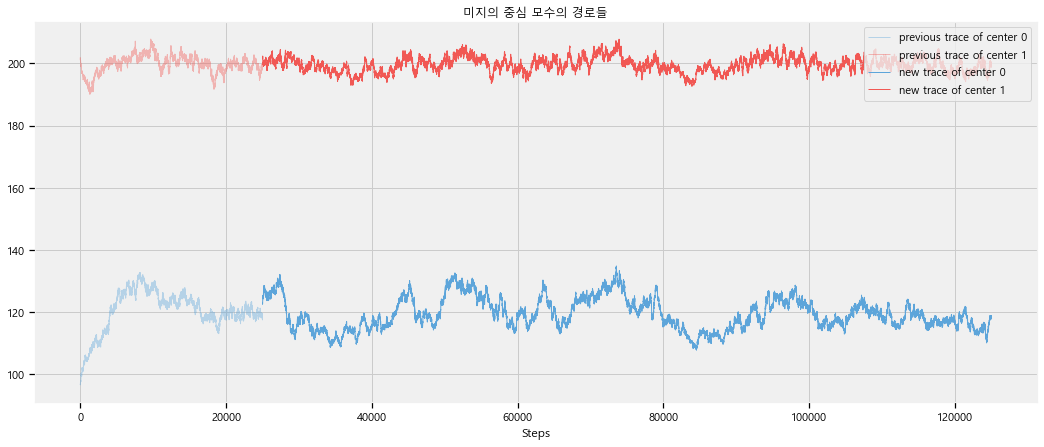

In [19]:
figsize(16, 7)
center_trace = posterior_2[1]
prev_center_trace = posterior_1[1]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0", lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1", lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 125000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#5DA5DA")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#F15854")

plt.title("미지의 중심 모수의 경로들")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

- 우리의 주된 목적은 클러스터를 확인하는 것. 중심과 표준편차의 사후확률을 나타냄

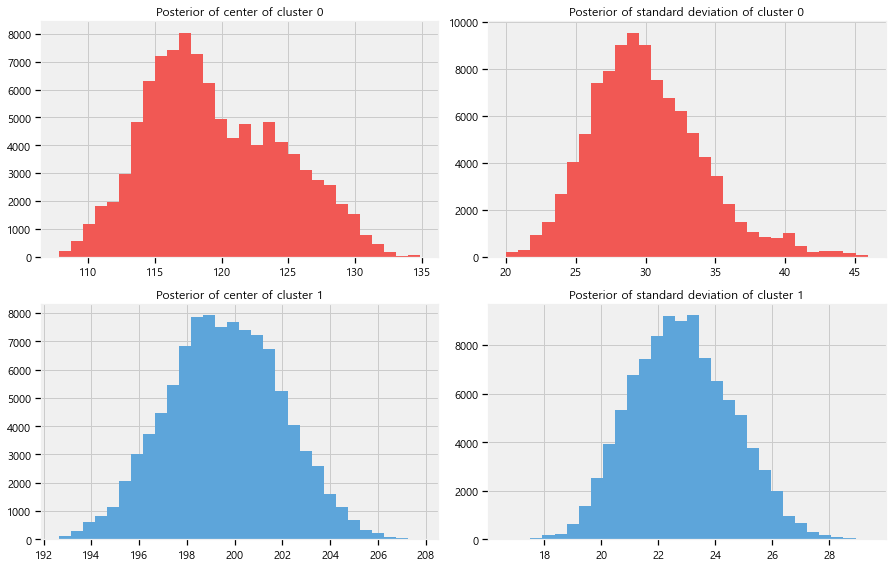

In [20]:
figsize(12.5, 8)
std_trace = posterior_2[2]
prev_std_trace = posterior_1[2]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30, histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

In [21]:
# put the data into a tensor
data_ = tf.constant(data, dtype=tf.float32)
data_ = data_[:, tf.newaxis]

# This produces a cluster per MCMC chain
rv_clusters_1 = tfd.Normal(posterior_2[1][:, 0], posterior_2[2][:, 0])
rv_clusters_2 = tfd.Normal(posterior_2[1][:, 1], posterior_2[2][:, 1])

# Compute the un-normalized log probabilities for each cluster
cluster_1_log_prob = rv_clusters_1.log_prob(data_) + tf.math.log(posterior_2[0])
cluster_2_log_prob = rv_clusters_2.log_prob(data_) + tf.math.log(1. - posterior_2[0])

x = tf.stack([cluster_1_log_prob, cluster_2_log_prob], axis=-1)
y = tf.math.reduce_logsumexp(x, -1)

# Bayes rule to compute the assignment probability: P(cluster = 1 | data) ∝ P(data | cluster = 1) P(cluster = 1)
log_p_assign_1 = cluster_1_log_prob - tf.math.reduce_logsumexp(tf.stack([cluster_1_log_prob, cluster_2_log_prob], axis=-1), -1)

# Average across the MCMC chain
log_p_assign_1 = tf.math.reduce_logsumexp(log_p_assign_1, -1) - tf.math.log(tf.cast(log_p_assign_1.shape[-1], tf.float32))
 
p_assign_1 = tf.exp(log_p_assign_1)
p_assign = tf.stack([p_assign_1, 1-p_assign_1], axis=-1)

# for charting 
probs_assignments = p_assign_1
burned_assignment_trace = tfd.Categorical(probs=p_assign).sample(sample_shape=200)

## 3.2 수렴 판정하기

### 3.2.1. Autocorrelation(자기상관)
- autocorrelation은 시계열이 자신과 얼마나 상관되어 있는가를 보여주는 척도.
- 측정값 1은 완전한 양의 자기상관이고, 0은 상관관계가 없고, -1은 완전한 음의 상관관계.
- 자기상관은 시점 $t$의 시계열 $x_t$가 시점 $t-k$의 $x_t-k$와 어떻게 상관되어 있는지를 파악함
$$R(k) = \text{Corr}( x_t, x_{t-k} )$$
- 예를 들어, 시계열이 두 개 있다고 했을 때
$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}( y_{t-1}, 1 ), \;\; y_0 = 0$$
둘의 예제 경로는 다음과 같다.

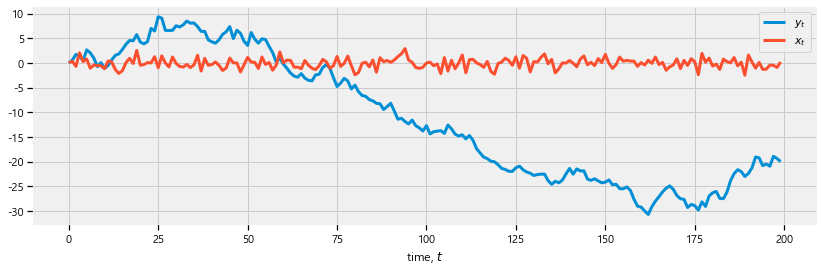

In [22]:
x_t = tfd.Normal(loc=0., scale=1.).sample(sample_shape=200)
x_t = x_t.numpy()
x_t[0] = 0
x_t = tf.convert_to_tensor(x_t)

y_t = np.zeros(200)

for i in range(1, 200):
    
    y_t[i] = tfd.Normal(loc=y_t[i - 1], scale=1.).sample()

figsize(12.5, 4)
plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();

- 만일 내가 시점 s에서 시계열의 위치를 알고 있다면 시점 t에서 나의 위치를 아는데 도움이 될 까?'
- 시계열 $x_t$에서 답변은 '아니오'임. 따라서 x는 독립확률변수.


- 이 밑에 블라블라 말들은 이해가 안됨

On the other hand,  is autocorrelated. By construction, if I knew that , I can be very confident that  will not be very far from 10. Similarly, I can even make a (less confident guess) about : it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about , but again, I am less confident. Taking this to it's logical conclusion, we must concede that as , the lag between time points, increases the autocorrelation decreases. We can visualize this:

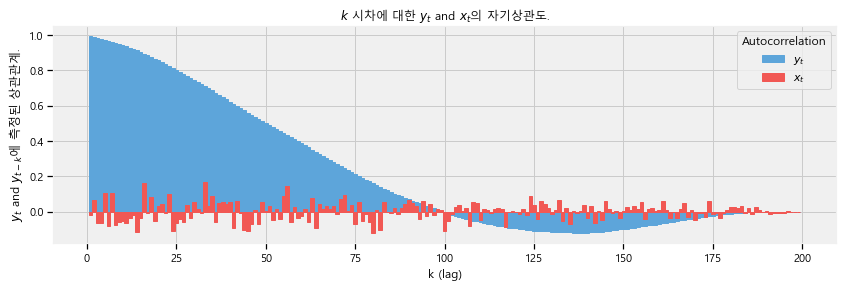

In [25]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = [TFColor[3], TFColor[0], TFColor[6]]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$", edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$", color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("$y_t$ and $y_{t-k}$에 측정된 상관관계.")
plt.xlabel("k (lag)")
plt.title("$k$ 시차에 대한 $y_t$ and $x_t$의 자기상관도.");

- $k$가 증가하면 $y_t$의 자기상관은 최고 고점에서 감소함. 
- $y_t$의 자기상관을 노이즈처럼 보이는 $x_t$의 자기상관과 비교하면 이 시계열에 자기상관이 없다는 결론을 내릴 수 있음.


#### MCMC 수렴과 무슨 관계?
- MCMC 알고리즘의 성격상 우리는 항상 자기상관관계를 보이는 표본을 얻었음(이는 알고리즘의 'walk' 단계 때문)
- 공간을 잘 탐색하고 있는 체인은 매우 높은 자기상관을 보여줌.
- 시각적으로 그 경로가 한 곳에 정지하는 것이 아니라 강처럼 구불구불 흐르는 듯 보이면 체인은 매우 높은 상관관계를 가짐.


- 반면, 낮은 상관관계를 가진다면 우리는 체인이 '잘 섞인 것(mixing well)'이라 말할 수 있음.

#### 3.2.2. 솎아내기
- 사후확률분포 표본 간 높은 상관관계가 있는 경우 또 다른 이슈가 일어날 수 있음.
- 많은 사후처리 알고리즘은 서로 독립적이어야 함. 이런 이슈는 사용자에게 매 n번째 표본을 돌려주거나 자기상관을 약간 제거하여 해결하거나 줄일 수 있음.

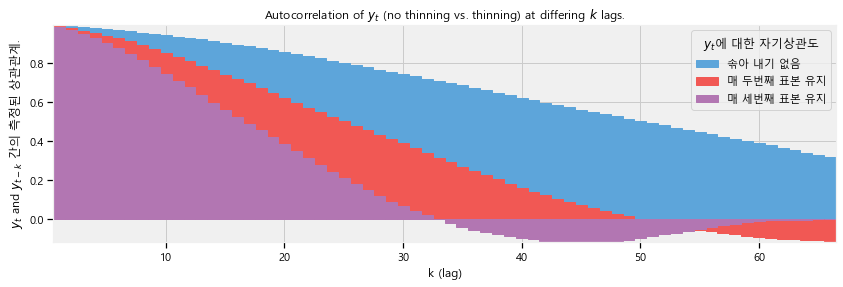

In [26]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0], label="솎아 내기 없음", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1], label="매 두번째 표본 유지", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2], label="매 세번째 표본 유지", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="$y_t$에 대한 자기상관도", loc="upper right")
plt.ylabel("$y_t$ and $y_{t-k}$ 간의 측정된 상관관계.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) at differing $k$ lags.");

- 솎아내기가 많을 수록 자기상관은 빠르게 줄어듬. 그러나 여기에는 상충적인 관계(tradeoff)가 있음.
- 더 높은 수준의 솎아내기는 MCMC를 더 많이 반복하여 같은 개수의 표본을 얻을 수 있음. 예를 들어 솎아내기가 되지 않은 10,000개의 표본은 솎아내기를 10으로 한 100,000개의 표본에 해당함(솎아내기한 십만개의 표본들이 자기상관이 적음)
- 적절한 양의 솎아내기 양과 상관없이 얻은 표본은 항상 어떤 상관관계를 보여줌. 따라서, 자기상관이 빠르게 0으로 줄어드는 한 괜찮음.

### Useful tips for MCMC
Bayesian inference would be the de facto method if it weren't for MCMC's computational difficulties. In fact, MCMC is what turns most users off practical Bayesian inference. Below I present some good heuristics to help convergence and speed up the MCMC engine:

#### Intelligent starting values
It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we think the posterior distribution will be by specifying the testval parameter in the Stochastic variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the  parameter, then a good starting value would be the mean of the data.

`mu = tfd.Uniform(name="mu", low=0., high=100.).sample(seed=data.mean())`

For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

#### Priors
If the priors are poorly chosen, the MCMC algorithm may not converge, or at least have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see Folk Theorem of Statistical Computing below).